# 问题2：反应条件预测

## 目标与概述

本notebook旨在使用反应数据集A构建多分类模型来预测最优反应条件。

**主要任务：**
1. 分析反应数据集A中催化剂、碱和溶剂的分布
2. 实现反应指纹和条件特征向量
3. 训练三个多分类模型（催化剂、碱、溶剂预测）
4. 评估模型性能并提供化学解释

**学生ID：153**  
**随机种子：1153, 2153, 3153, 4153, 5153**

## 1. 导入所需库

导入用于数据处理、机器学习和可视化的必要Python库。

In [1]:
# 数据处理和科学计算
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# 机器学习
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.multioutput import MultiOutputClassifier

# 化学信息学
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# 设置中文字体和绘图风格
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8')

# 随机种子设置（基于学生ID：153）
STUDENT_ID = 153
RANDOM_SEEDS = [1153, 2153, 3153, 4153, 5153]

print("库导入完成！")
print(f"学生ID: {STUDENT_ID}")
print(f"随机种子: {RANDOM_SEEDS}")

库导入完成！
学生ID: 153
随机种子: [1153, 2153, 3153, 4153, 5153]


## 2. 加载反应数据集A

从datasets/Reaction_Dataset_A.csv加载反应数据集，检查数据结构和基本信息。

In [28]:
def load_reaction_dataset_a(file_path):
    """
    加载反应数据集A
    - 读取datasets/Reaction_Dataset_A.csv
    - 返回反应数据DataFrame
    """
    try:
        df = pd.read_csv(file_path)
        print(f"✓ 成功加载反应数据集A")
        print(f"  数据形状: {df.shape}")
        print(f"  列名: {list(df.columns)}")
        
        # 显示基本信息
        print(f"\n数据集基本信息:")
        print(f"  样本数量: {len(df)}")
        print(f"  特征数量: {len(df.columns)}")
        
        # 显示前几行
        print(f"\n前5行数据:")
        print(df.head())
        
        # 检查缺失值
        missing_values = df.isnull().sum()
        if missing_values.sum() > 0:
            print(f"\n缺失值统计:")
            print(missing_values[missing_values > 0])
        else:
            print(f"\n✓ 无缺失值")
            
        return df
        
    except FileNotFoundError:
        print(f"✗ 未找到文件: {file_path}")
        return None
    except Exception as e:
        print(f"✗ 加载数据时出错: {str(e)}")
        return None

# 加载数据集 - 修复路径
dataset_path = "dataset/Reaction Dataset A.csv"  # 正确的路径
reaction_df = load_reaction_dataset_a(dataset_path)

✓ 成功加载反应数据集A
  数据形状: (3696, 7)
  列名: ['entry', 'Electrophile_SMILES', 'Nucleophile_SMILES', 'Ligand_SMILES', 'Base_SMILES', 'Solvent_SMILES', 'yield']

数据集基本信息:
  样本数量: 3696
  特征数量: 7

前5行数据:
   entry      Electrophile_SMILES                   Nucleophile_SMILES  \
0      1  ClC1=CC=C(N=CC=C2)C2=C1  CC1=CC=C(N(C2CCCCO2)N=C3)C3=C1B(O)O   
1      2  ClC1=CC=C(N=CC=C2)C2=C1  CC1=CC=C(N(C2CCCCO2)N=C3)C3=C1B(O)O   
2      3  ClC1=CC=C(N=CC=C2)C2=C1  CC1=CC=C(N(C2CCCCO2)N=C3)C3=C1B(O)O   
3      4  ClC1=CC=C(N=CC=C2)C2=C1  CC1=CC=C(N(C2CCCCO2)N=C3)C3=C1B(O)O   
4      5  ClC1=CC=C(N=CC=C2)C2=C1  CC1=CC=C(N(C2CCCCO2)N=C3)C3=C1B(O)O   

                             Ligand_SMILES  Base_SMILES Solvent_SMILES  yield  
0              CC(P(C(C)(C)C)C(C)(C)C)(C)C  [Na+].[OH-]           N#CC   4.76  
1   P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3  [Na+].[OH-]           N#CC   4.12  
2    CC(C)(C)P(C(C)(C)C)C1=CC=C(N(C)C)C=C1  [Na+].[OH-]           N#CC   2.58  
3            P(C1CCCCC1)(C2CCCCC2)C3CCCCC3 

## 3. 分析反应条件分布

分析催化剂、碱和溶剂的分布情况，统计各类别的频率，生成分布图表和统计摘要。

识别到的反应条件列: ['Ligand_SMILES', 'Base_SMILES', 'Solvent_SMILES']

Ligand_SMILES 分布:
  唯一值数量: 11
  前5名:
    1. CC(P(C(C)(C)C)C(C)(C)C)(C)C: 336 (9.09%)
    2. P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3: 336 (9.09%)
    3. CC(C)(C)P(C(C)(C)C)C1=CC=C(N(C)C)C=C1: 336 (9.09%)
    4. P(C1CCCCC1)(C2CCCCC2)C3CCCCC3: 336 (9.09%)
    5. CC1=CC=CC=C1P(C2=CC=CC=C2C)C3=CC=CC=C3C: 336 (9.09%)

Base_SMILES 分布:
  唯一值数量: 7
  前5名:
    1. [Na+].[OH-]: 528 (14.29%)
    2. OC([O-])=O.[Na+]: 528 (14.29%)
    3. [Cs+].[F-]: 528 (14.29%)
    4. O=P([O-])([O-])[O-].[K+].[K+].[K+]: 528 (14.29%)
    5. [K+].[OH-]: 528 (14.29%)

Solvent_SMILES 分布:
  唯一值数量: 4
  前5名:
    1. N#CC: 924 (25.00%)
    2. C1COCC1: 924 (25.00%)
    3. O=CN(C)C: 924 (25.00%)
    4. CO: 924 (25.00%)


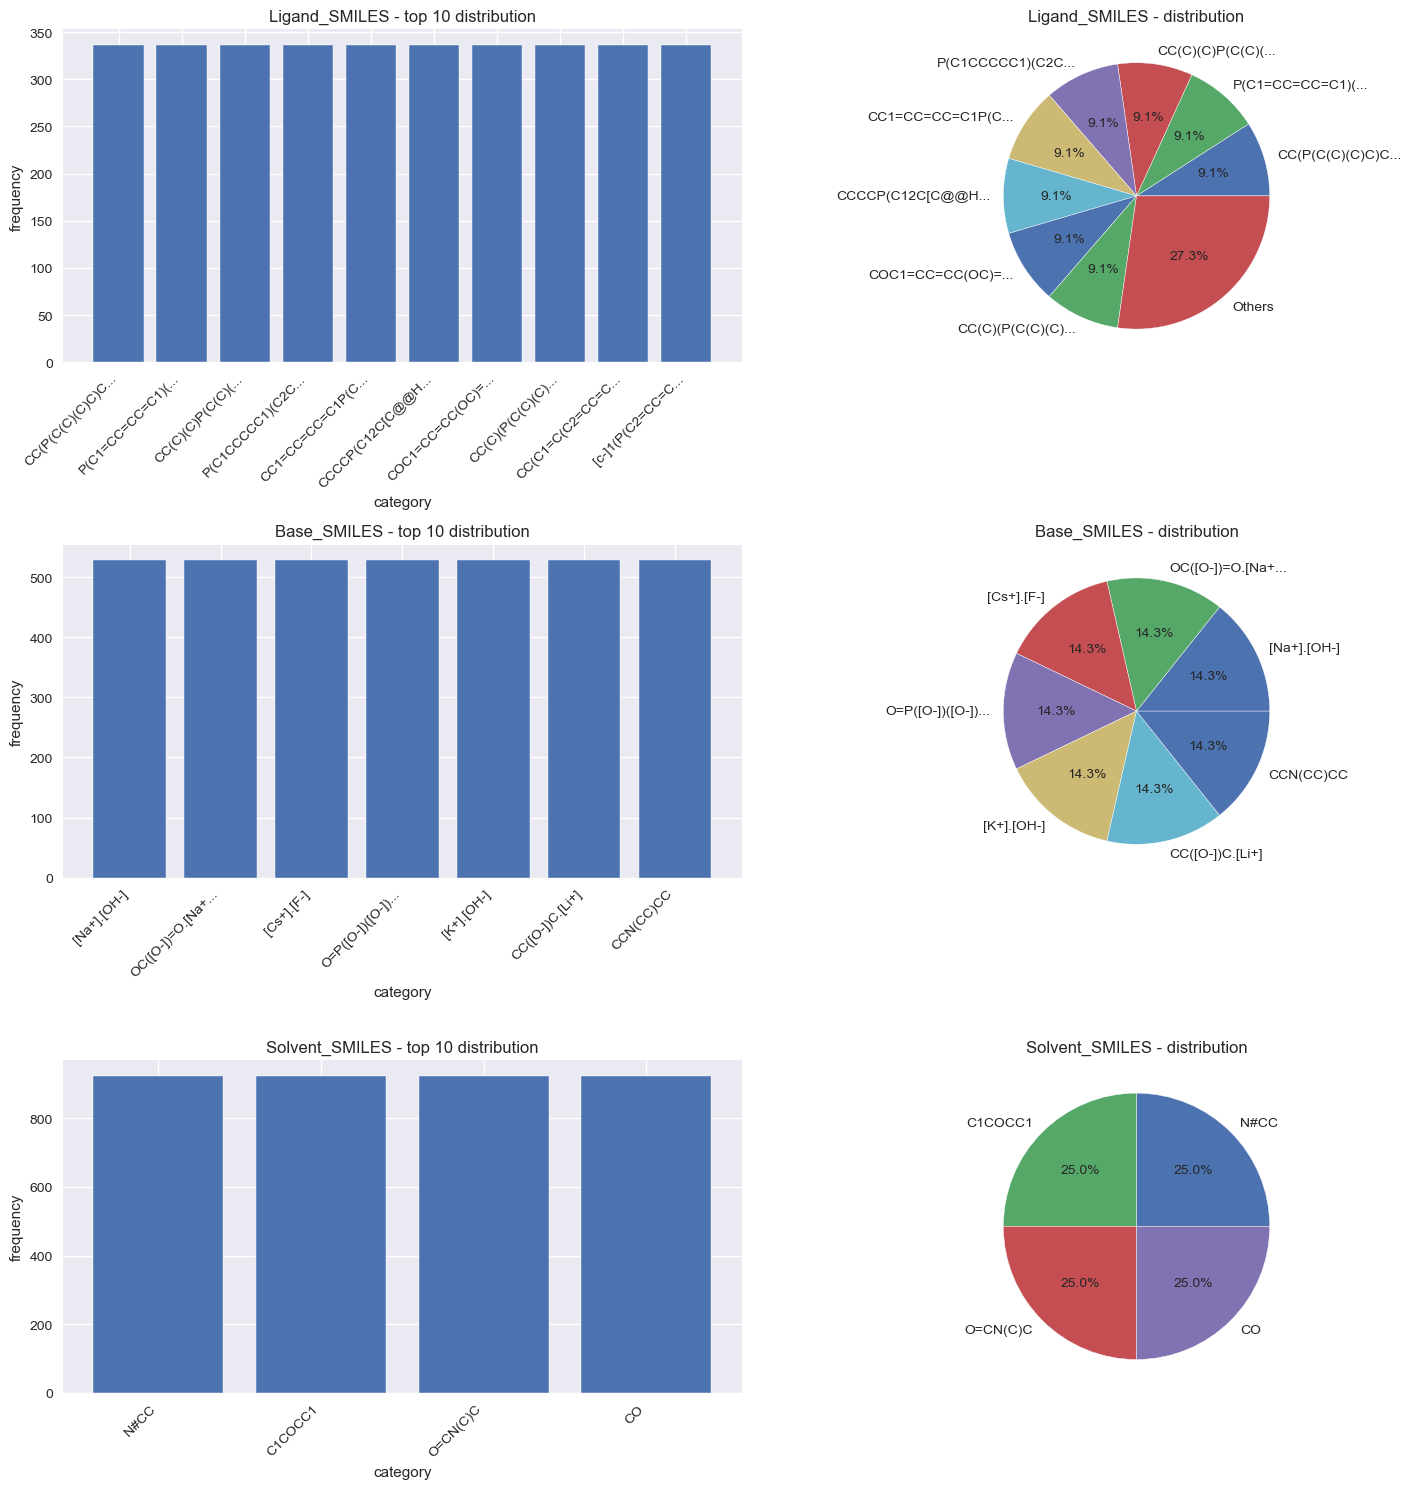

In [39]:
def analyze_reaction_conditions_distribution(df):
    """
    分析催化剂、碱和溶剂的分布
    - 统计各类别的频率
    - 生成分布图表
    - 返回分布分析
    """
    if df is None or df.empty:
        print("错误：数据框为空")
        return None
    
    # 识别反应条件列
    condition_columns = []
    for col in df.columns:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in ['catalyst', 'base', 'solvent', 'ligand']):
            condition_columns.append(col)
    
    print(f"识别到的反应条件列: {condition_columns}")
    
    if not condition_columns:
        print("未找到反应条件相关列")
        return None
    
    # 分析每个条件的分布
    distribution_analysis = {}
    
    fig, axes = plt.subplots(len(condition_columns), 2, figsize=(15, 5*len(condition_columns)))
    if len(condition_columns) == 1:
        axes = axes.reshape(1, -1)
    
    for i, col in enumerate(condition_columns):
        # 统计分布
        value_counts = df[col].value_counts()
        distribution_analysis[col] = {
            'unique_count': len(value_counts),
            'top_5': value_counts.head().to_dict(),
            'distribution': value_counts.to_dict()
        }
        
        print(f"\n{col} 分布:")
        print(f"  唯一值数量: {len(value_counts)}")
        print(f"  前5名:")
        for j, (value, count) in enumerate(value_counts.head().items(), 1):
            percentage = (count / len(df)) * 100
            print(f"    {j}. {value}: {count} ({percentage:.2f}%)")
        
        # 可视化
        # 条形图（前10个）
        top_10 = value_counts.head(10)
        axes[i, 0].bar(range(len(top_10)), top_10.values)
        axes[i, 0].set_title(f'{col} - top 10 distribution')
        axes[i, 0].set_xlabel('category')
        axes[i, 0].set_ylabel('frequency')
        axes[i, 0].set_xticks(range(len(top_10)))
        axes[i, 0].set_xticklabels([str(x)[:15] + '...' if len(str(x)) > 15 else str(x) 
                                   for x in top_10.index], rotation=45, ha='right')
        
        # 饼图（前8个）
        top_8 = value_counts.head(8)
        others = value_counts.iloc[8:].sum() if len(value_counts) > 8 else 0
        
        if others > 0:
            plot_data = list(top_8.values) + [others]
            plot_labels = [str(x)[:15] + '...' if len(str(x)) > 15 else str(x) 
                          for x in top_8.index] + ['Others']
        else:
            plot_data = top_8.values
            plot_labels = [str(x)[:15] + '...' if len(str(x)) > 15 else str(x) 
                          for x in top_8.index]
        
        axes[i, 1].pie(plot_data, labels=plot_labels, autopct='%1.1f%%')
        axes[i, 1].set_title(f'{col} - distribution')
    
    plt.tight_layout()
    
    # 创建目录并保存图表
    os.makedirs('submission/figures', exist_ok=True)
    plt.savefig('submission/figures/reaction_conditions_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return distribution_analysis

# 执行反应条件分布分析
if reaction_df is not None:
    conditions_analysis = analyze_reaction_conditions_distribution(reaction_df)
else:
    print("无法进行分布分析：反应数据框为空")

## 4. 处理分类变量编码

对催化剂、碱、溶剂等分类变量进行编码处理，为后续的机器学习模型做准备。

In [33]:
def encode_categorical_variables(df, categorical_columns):
    """
    处理分类变量并创建适当的编码
    - 实现标签编码或独热编码
    - 返回编码后的数据
    """
    if df is None or df.empty:
        print("错误：输入数据框为空")
        return None, None
    
    df_encoded = df.copy()
    encoders = {}
    
    print("对分类变量进行标签编码...")
    
    for col in categorical_columns:
        if col in df_encoded.columns:
            # 使用标签编码器
            le = LabelEncoder()
            
            # 处理缺失值
            df_encoded[col] = df_encoded[col].fillna('Unknown')
            
            # 编码
            df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col].astype(str))
            encoders[col] = le
            
            print(f"✓ {col}: {len(le.classes_)} 个唯一类别")
            print(f"  类别示例: {list(le.classes_[:5])}")
            
    return df_encoded, encoders

def identify_reaction_columns(df):
    """
    自动识别反应相关的列
    """
    reaction_cols = {
        'reactant_smiles': None,
        'catalyst': None,
        'base': None,
        'solvent': None,
        'yield': None
    }
    
    for col in df.columns:
        col_lower = col.lower()
        
        # 识别反应物SMILES (包含Electrophile)
        if any(keyword in col_lower for keyword in ['electrophile', 'reactant', 'substrate']):
            if reaction_cols['reactant_smiles'] is None and 'smiles' in col_lower:
                reaction_cols['reactant_smiles'] = col
        
        # 识别配体（作为催化剂）
        elif 'ligand' in col_lower and 'smiles' in col_lower:
            if reaction_cols['catalyst'] is None:
                reaction_cols['catalyst'] = col
        
        # 识别碱
        elif 'base' in col_lower and 'smiles' in col_lower:
            if reaction_cols['base'] is None:
                reaction_cols['base'] = col
        
        # 识别溶剂
        elif 'solvent' in col_lower and 'smiles' in col_lower:
            if reaction_cols['solvent'] is None:
                reaction_cols['solvent'] = col
        
        # 识别收率
        elif 'yield' in col_lower:
            if reaction_cols['yield'] is None:
                reaction_cols['yield'] = col
    
    print("识别的反应相关列:")
    for key, value in reaction_cols.items():
        print(f"  {key}: {value}")
    
    return reaction_cols

# 识别和编码分类变量
if reaction_df is not None:
    # 识别反应相关列
    reaction_columns = identify_reaction_columns(reaction_df)
    
    # 确定需要编码的分类列
    categorical_cols = []
    for key, col_name in reaction_columns.items():
        if col_name is not None and key in ['catalyst', 'base', 'solvent']:
            categorical_cols.append(col_name)
    
    print(f"\n需要编码的分类列: {categorical_cols}")
    
    if categorical_cols:
        # 执行编码
        encoded_df, label_encoders = encode_categorical_variables(reaction_df, categorical_cols)
        print(f"\n✓ 分类变量编码完成")
    else:
        print("未找到需要编码的分类列")
        encoded_df = reaction_df.copy()
        label_encoders = {}
else:
    print("无法进行编码：反应数据框为空")

识别的反应相关列:
  reactant_smiles: Electrophile_SMILES
  catalyst: Ligand_SMILES
  base: Base_SMILES
  solvent: Solvent_SMILES
  yield: yield

需要编码的分类列: ['Ligand_SMILES', 'Base_SMILES', 'Solvent_SMILES']
对分类变量进行标签编码...
✓ Ligand_SMILES: 11 个唯一类别
  类别示例: ['CC(C)(C)P(C(C)(C)C)C1=CC=C(N(C)C)C=C1', 'CC(C)(P(C(C)(C)C)[c-]1cccc1)C.CC(C)(P(C(C)(C)C)[c-]2cccc2)C.[Fe+2]', 'CC(C1=C(C2=CC=CC=C2P(C3CCCCC3)C4CCCCC4)C(C(C)C)=CC(C(C)C)=C1)C', 'CC(P(C(C)(C)C)C(C)(C)C)(C)C', 'CC1(C)C2=C(OC3=C1C=CC=C3P(C4=CC=CC=C4)C5=CC=CC=C5)C(P(C6=CC=CC=C6)C7=CC=CC=C7)=CC=C2']
✓ Base_SMILES: 7 个唯一类别
  类别示例: ['CC([O-])C.[Li+]', 'CCN(CC)CC', 'O=P([O-])([O-])[O-].[K+].[K+].[K+]', 'OC([O-])=O.[Na+]', '[Cs+].[F-]']
✓ Solvent_SMILES: 4 个唯一类别
  类别示例: ['C1COCC1', 'CO', 'N#CC', 'O=CN(C)C']

✓ 分类变量编码完成


## 5. 实现反应指纹

使用反应物的SMILES字符串计算分子指纹，并组合成反应指纹矩阵。

In [31]:
def implement_reaction_fingerprints(reactant_smiles, radius=2, n_bits=2048):
    """
    使用反应物分子指纹实现反应指纹
    - 计算反应物的分子指纹
    - 组合成反应指纹
    - 返回反应指纹矩阵
    """
    print(f"生成反应指纹 (radius={radius}, n_bits={n_bits})...")
    
    fingerprints = []
    failed_count = 0
    
    for i, smiles in enumerate(reactant_smiles):
        try:
            if pd.isna(smiles) or smiles == '':
                fingerprints.append([0] * n_bits)
                failed_count += 1
                continue
                
            # 处理可能包含多个SMILES的情况（用点分隔）
            smiles_parts = str(smiles).split('.')
            
            # 为每个反应物计算指纹
            mol_fingerprints = []
            for smiles_part in smiles_parts:
                mol = Chem.MolFromSmiles(smiles_part.strip())
                if mol is not None:
                    fp = GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
                    mol_fingerprints.append(np.array(fp))
                else:
                    mol_fingerprints.append(np.zeros(n_bits))
            
            # 组合反应物指纹（取平均值或最大值）
            if mol_fingerprints:
                combined_fp = np.mean(mol_fingerprints, axis=0)
                # 将连续值转换为二进制（阈值0.5）
                combined_fp = (combined_fp > 0.5).astype(int)
                fingerprints.append(combined_fp.tolist())
            else:
                fingerprints.append([0] * n_bits)
                failed_count += 1
                
        except Exception as e:
            fingerprints.append([0] * n_bits)
            failed_count += 1
    
    fingerprint_array = np.array(fingerprints)
    
    print(f"✓ 反应指纹生成完成")
    print(f"  成功: {len(reactant_smiles) - failed_count}/{len(reactant_smiles)}")
    print(f"  指纹矩阵形状: {fingerprint_array.shape}")
    
    return fingerprint_array

def validate_smiles_in_dataset(df, smiles_column):
    """
    验证数据集中的SMILES字符串
    """
    if smiles_column not in df.columns:
        print(f"错误：未找到SMILES列 '{smiles_column}'")
        return df
    
    print(f"验证SMILES列: {smiles_column}")
    
    valid_count = 0
    invalid_count = 0
    
    for smiles in df[smiles_column]:
        if pd.isna(smiles) or smiles == '':
            invalid_count += 1
            continue
            
        try:
            # 处理多个SMILES的情况
            smiles_parts = str(smiles).split('.')
            all_valid = True
            
            for smiles_part in smiles_parts:
                mol = Chem.MolFromSmiles(smiles_part.strip())
                if mol is None:
                    all_valid = False
                    break
            
            if all_valid:
                valid_count += 1
            else:
                invalid_count += 1
                
        except Exception:
            invalid_count += 1
    
    print(f"SMILES验证结果:")
    print(f"  有效SMILES: {valid_count}")
    print(f"  无效SMILES: {invalid_count}")
    print(f"  有效率: {valid_count/(valid_count+invalid_count)*100:.2f}%")
    
    return df

# 实现反应指纹
if encoded_df is not None and reaction_columns['reactant_smiles'] is not None:
    smiles_col = reaction_columns['reactant_smiles']
    
    # 验证SMILES
    validated_df = validate_smiles_in_dataset(encoded_df, smiles_col)
    
    # 生成反应指纹
    reaction_smiles = validated_df[smiles_col].tolist()
    reaction_fingerprints = implement_reaction_fingerprints(reaction_smiles)
    
    print(f"\n✓ 反应指纹矩阵形状: {reaction_fingerprints.shape}")
    
else:
    print("无法生成反应指纹：缺少必要数据或SMILES列")
    reaction_fingerprints = None

验证SMILES列: Electrophile_SMILES
SMILES验证结果:
  有效SMILES: 3696
  无效SMILES: 0
  有效率: 100.00%
生成反应指纹 (radius=2, n_bits=2048)...


[14:38:27] DEPRECATION WARNING: please use MorganGenerator
[14:38:27] DEPRECATION WARNING: please use MorganGenerator
[14:38:27] DEPRECATION WARNING: please use MorganGenerator
[14:38:27] DEPRECATION WARNING: please use MorganGenerator
[14:38:27] DEPRECATION WARNING: please use MorganGenerator
[14:38:27] DEPRECATION WARNING: please use MorganGenerator
[14:38:27] DEPRECATION WARNING: please use MorganGenerator
[14:38:27] DEPRECATION WARNING: please use MorganGenerator
[14:38:27] DEPRECATION WARNING: please use MorganGenerator
[14:38:27] DEPRECATION WARNING: please use MorganGenerator
[14:38:27] DEPRECATION WARNING: please use MorganGenerator
[14:38:27] DEPRECATION WARNING: please use MorganGenerator
[14:38:27] DEPRECATION WARNING: please use MorganGenerator
[14:38:27] DEPRECATION WARNING: please use MorganGenerator
[14:38:27] DEPRECATION WARNING: please use MorganGenerator
[14:38:27] DEPRECATION WARNING: please use MorganGenerator
[14:38:27] DEPRECATION WARNING: please use MorganGenerat

✓ 反应指纹生成完成
  成功: 3696/3696
  指纹矩阵形状: (3696, 2048)

✓ 反应指纹矩阵形状: (3696, 2048)


## 6. 创建条件特征向量

为催化剂、碱、溶剂组合创建特征向量，编码反应条件信息。

In [34]:
def create_condition_feature_vectors(catalyst_list, base_list, solvent_list, encoders):
    """
    创建条件特征向量（催化剂、碱、溶剂组合）
    - 编码反应条件
    - 返回条件特征矩阵
    """
    print("创建条件特征向量...")
    
    condition_features = []
    
    # 获取编码器
    catalyst_encoder = encoders.get(reaction_columns['catalyst'])
    base_encoder = encoders.get(reaction_columns['base'])
    solvent_encoder = encoders.get(reaction_columns['solvent'])
    
    for i in range(len(catalyst_list)):
        features = []
        
        # 催化剂特征
        if catalyst_encoder is not None:
            catalyst = str(catalyst_list[i]) if not pd.isna(catalyst_list[i]) else 'Unknown'
            try:
                cat_encoded = catalyst_encoder.transform([catalyst])[0]
            except ValueError:
                cat_encoded = -1  # 未知类别
            features.append(cat_encoded)
        
        # 碱特征
        if base_encoder is not None:
            base = str(base_list[i]) if not pd.isna(base_list[i]) else 'Unknown'
            try:
                base_encoded = base_encoder.transform([base])[0]
            except ValueError:
                base_encoded = -1  # 未知类别
            features.append(base_encoded)
        
        # 溶剂特征
        if solvent_encoder is not None:
            solvent = str(solvent_list[i]) if not pd.isna(solvent_list[i]) else 'Unknown'
            try:
                solvent_encoded = solvent_encoder.transform([solvent])[0]
            except ValueError:
                solvent_encoded = -1  # 未知类别
            features.append(solvent_encoded)
        
        condition_features.append(features)
    
    condition_array = np.array(condition_features)
    
    print(f"✓ 条件特征向量创建完成")
    print(f"  特征矩阵形状: {condition_array.shape}")
    print(f"  特征维度: 催化剂(1) + 碱(1) + 溶剂(1) = {condition_array.shape[1]}")
    
    return condition_array

def combine_molecular_condition_features(mol_features, condition_features):
    """
    适当地组合分子和条件特征
    - 特征连接或其他组合方法
    - 返回组合特征矩阵
    """
    print("组合分子指纹和条件特征...")
    
    if mol_features is None or condition_features is None:
        print("错误：缺少必要的特征矩阵")
        return None
    
    # 检查样本数量是否匹配
    if mol_features.shape[0] != condition_features.shape[0]:
        print(f"错误：样本数量不匹配 - 分子特征: {mol_features.shape[0]}, 条件特征: {condition_features.shape[0]}")
        return None
    
    # 简单连接
    combined_features = np.hstack([mol_features, condition_features])
    
    print(f"✓ 特征组合完成")
    print(f"  分子指纹维度: {mol_features.shape[1]}")
    print(f"  条件特征维度: {condition_features.shape[1]}")
    print(f"  组合特征维度: {combined_features.shape[1]}")
    print(f"  总样本数: {combined_features.shape[0]}")
    
    return combined_features

# 创建条件特征向量
if encoded_df is not None and label_encoders:
    # 获取条件列的数据
    catalyst_data = encoded_df[reaction_columns['catalyst']].tolist() if reaction_columns['catalyst'] else []
    base_data = encoded_df[reaction_columns['base']].tolist() if reaction_columns['base'] else []
    solvent_data = encoded_df[reaction_columns['solvent']].tolist() if reaction_columns['solvent'] else []
    
    # 创建条件特征
    condition_features = create_condition_feature_vectors(
        catalyst_data, base_data, solvent_data, label_encoders
    )
    
    # 组合分子指纹和条件特征
    if reaction_fingerprints is not None:
        combined_features = combine_molecular_condition_features(
            reaction_fingerprints, condition_features
        )
        print(f"\n✓ 最终特征矩阵形状: {combined_features.shape}")
    else:
        print("警告：使用仅条件特征（无分子指纹）")
        combined_features = condition_features
        
else:
    print("无法创建条件特征：缺少编码数据或编码器")
    condition_features = None
    combined_features = None

创建条件特征向量...
✓ 条件特征向量创建完成
  特征矩阵形状: (3696, 3)
  特征维度: 催化剂(1) + 碱(1) + 溶剂(1) = 3
组合分子指纹和条件特征...
✓ 特征组合完成
  分子指纹维度: 2048
  条件特征维度: 3
  组合特征维度: 2051
  总样本数: 3696

✓ 最终特征矩阵形状: (3696, 2051)
✓ 条件特征向量创建完成
  特征矩阵形状: (3696, 3)
  特征维度: 催化剂(1) + 碱(1) + 溶剂(1) = 3
组合分子指纹和条件特征...
✓ 特征组合完成
  分子指纹维度: 2048
  条件特征维度: 3
  组合特征维度: 2051
  总样本数: 3696

✓ 最终特征矩阵形状: (3696, 2051)


## 7. 训练催化剂预测模型

使用组合特征训练多分类模型来预测最佳催化剂选择。

In [35]:
def train_catalyst_prediction_model(X, y_catalyst, random_state):
    """
    训练催化剂选择预测模型
    - 多分类模型训练
    - 返回训练好的模型
    """
    print(f"训练催化剂预测模型 (random_state={random_state})...")
    
    # 检查目标变量
    unique_catalysts = np.unique(y_catalyst)
    print(f"  催化剂类别数: {len(unique_catalysts)}")
    print(f"  催化剂类别: {unique_catalysts[:10]}")  # 显示前10个
    
    # 创建随机森林分类器
    catalyst_model = RandomForestClassifier(
        n_estimators=100,
        random_state=random_state,
        n_jobs=-1,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced'  # 处理类别不平衡
    )
    
    # 训练模型
    catalyst_model.fit(X, y_catalyst)
    
    print(f"✓ 催化剂预测模型训练完成")
    
    return catalyst_model

def train_base_prediction_model(X, y_base, random_state):
    """
    训练最佳碱选择模型
    - 多分类模型训练
    - 返回训练好的模型
    """
    print(f"训练碱预测模型 (random_state={random_state})...")
    
    # 检查目标变量
    unique_bases = np.unique(y_base)
    print(f"  碱类别数: {len(unique_bases)}")
    print(f"  碱类别: {unique_bases[:10]}")  # 显示前10个
    
    # 创建随机森林分类器
    base_model = RandomForestClassifier(
        n_estimators=100,
        random_state=random_state,
        n_jobs=-1,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced'
    )
    
    # 训练模型
    base_model.fit(X, y_base)
    
    print(f"✓ 碱预测模型训练完成")
    
    return base_model

def train_solvent_prediction_model(X, y_solvent, random_state):
    """
    训练合适溶剂预测模型
    - 多分类模型训练
    - 返回训练好的模型
    """
    print(f"训练溶剂预测模型 (random_state={random_state})...")
    
    # 检查目标变量
    unique_solvents = np.unique(y_solvent)
    print(f"  溶剂类别数: {len(unique_solvents)}")
    print(f"  溶剂类别: {unique_solvents[:10]}")  # 显示前10个
    
    # 创建随机森林分类器
    solvent_model = RandomForestClassifier(
        n_estimators=100,
        random_state=random_state,
        n_jobs=-1,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced'
    )
    
    # 训练模型
    solvent_model.fit(X, y_solvent)
    
    print(f"✓ 溶剂预测模型训练完成")
    
    return solvent_model

# 准备训练数据和目标变量
if combined_features is not None and encoded_df is not None:
    X = combined_features
    
    # 准备目标变量（使用编码后的值）
    y_catalyst = encoded_df[reaction_columns['catalyst'] + '_encoded'].values if reaction_columns['catalyst'] else None
    y_base = encoded_df[reaction_columns['base'] + '_encoded'].values if reaction_columns['base'] else None
    y_solvent = encoded_df[reaction_columns['solvent'] + '_encoded'].values if reaction_columns['solvent'] else None
    
    print(f"准备训练数据:")
    print(f"  特征矩阵形状: {X.shape}")
    print(f"  催化剂目标: {y_catalyst.shape if y_catalyst is not None else 'None'}")
    print(f"  碱目标: {y_base.shape if y_base is not None else 'None'}")
    print(f"  溶剂目标: {y_solvent.shape if y_solvent is not None else 'None'}")
    
    # 数据预处理（标准化特征）
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 训练模型
    trained_models = {}
    
    if y_catalyst is not None:
        catalyst_model = train_catalyst_prediction_model(X_scaled, y_catalyst, RANDOM_SEEDS[0])
        trained_models['catalyst'] = catalyst_model
    
    if y_base is not None:    
        base_model = train_base_prediction_model(X_scaled, y_base, RANDOM_SEEDS[0])
        trained_models['base'] = base_model
    
    if y_solvent is not None:
        solvent_model = train_solvent_prediction_model(X_scaled, y_solvent, RANDOM_SEEDS[0])
        trained_models['solvent'] = solvent_model
    
    print(f"\n✓ 所有模型训练完成，训练了 {len(trained_models)} 个模型")
    
else:
    print("无法训练模型：缺少特征数据或编码数据")
    trained_models = {}
    X_scaled = None

准备训练数据:
  特征矩阵形状: (3696, 2051)
  催化剂目标: (3696,)
  碱目标: (3696,)
  溶剂目标: (3696,)
训练催化剂预测模型 (random_state=1153)...
  催化剂类别数: 11
  催化剂类别: [0 1 2 3 4 5 6 7 8 9]
✓ 催化剂预测模型训练完成
训练碱预测模型 (random_state=1153)...
  碱类别数: 7
  碱类别: [0 1 2 3 4 5 6]
✓ 催化剂预测模型训练完成
训练碱预测模型 (random_state=1153)...
  碱类别数: 7
  碱类别: [0 1 2 3 4 5 6]
✓ 碱预测模型训练完成
训练溶剂预测模型 (random_state=1153)...
  溶剂类别数: 4
  溶剂类别: [0 1 2 3]
✓ 碱预测模型训练完成
训练溶剂预测模型 (random_state=1153)...
  溶剂类别数: 4
  溶剂类别: [0 1 2 3]
✓ 溶剂预测模型训练完成

✓ 所有模型训练完成，训练了 3 个模型
✓ 溶剂预测模型训练完成

✓ 所有模型训练完成，训练了 3 个模型


## 8. 评估分类模型性能

使用accuracy、precision、recall、F1-score等指标评估模型性能，生成混淆矩阵。

数据分割完成:
  训练集大小: (2956, 2051)
  测试集大小: (740, 2051)
评估分类模型性能...

评估 catalyst 模型:
----------------------------------------
准确率 (Accuracy): 0.9743
精确率 (Precision): 0.9757
召回率 (Recall): 0.9743
F1分数: 0.9745

详细分类报告:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       1.00      1.00      1.00        67
           2       1.00      1.00      1.00        68
           3       0.95      0.90      0.92        67
           4       0.86      0.96      0.91        67
           5       1.00      0.96      0.98        67
           6       1.00      0.96      0.98        67
           7       0.96      1.00      0.98        67
           8       0.96      1.00      0.98        68
           9       1.00      0.96      0.98        67
          10       1.00      1.00      1.00        68

    accuracy                           0.97       740
   macro avg       0.98      0.97      0.97       740
weighted avg       0.98      0.

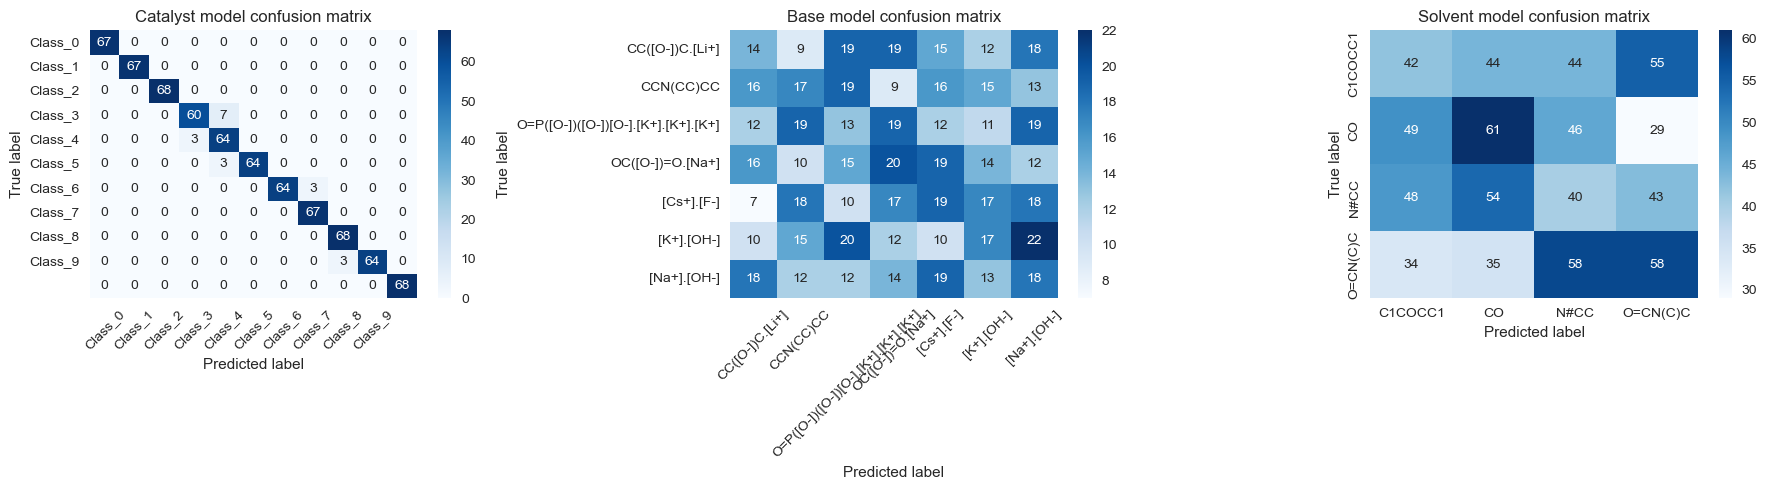

执行 5 折交叉验证...

catalyst 模型交叉验证:
  交叉验证准确率: [0.97972973 0.96481732 0.9729364  0.9594046  0.98105548]
  平均准确率: 0.9716 ± 0.0084

base 模型交叉验证:
  交叉验证准确率: [0.99594595 0.99594046 1.         0.99594046 1.        ]
  平均准确率: 0.9976 ± 0.0020

solvent 模型交叉验证:
  交叉验证准确率: [1. 1. 1. 1. 1.]
  平均准确率: 1.0000 ± 0.0000


In [40]:
def evaluate_classification_models(models_dict, X_test, y_test_dict, label_encoders):
    """
    使用适当的评估指标评估模型
    - 计算accuracy, precision, recall, F1-score
    - 生成混淆矩阵
    - 返回评估结果
    """
    print("评估分类模型性能...")
    
    evaluation_results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n评估 {model_name} 模型:")
        print("-" * 40)
        
        if model_name not in y_test_dict:
            print(f"跳过 {model_name}：缺少测试标签")
            continue
        
        y_test = y_test_dict[model_name]
        y_pred = model.predict(X_test)
        
        # 计算基本指标
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, support = precision_recall_fscore_support(
            y_test, y_pred, average='weighted', zero_division=0
        )
        
        # 分类报告
        class_report = classification_report(y_test, y_pred, zero_division=0)
        
        # 混淆矩阵
        cm = confusion_matrix(y_test, y_pred)
        
        evaluation_results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'classification_report': class_report,
            'confusion_matrix': cm,
            'y_true': y_test,
            'y_pred': y_pred
        }
        
        print(f"准确率 (Accuracy): {accuracy:.4f}")
        print(f"精确率 (Precision): {precision:.4f}")
        print(f"召回率 (Recall): {recall:.4f}")
        print(f"F1分数: {f1:.4f}")
        
        print(f"\n详细分类报告:")
        print(class_report)
    
    return evaluation_results

def plot_confusion_matrices(evaluation_results, label_encoders):
    """
    绘制混淆矩阵
    """
    n_models = len(evaluation_results)
    if n_models == 0:
        return
        
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    if n_models == 1:
        axes = [axes]
    
    for i, (model_name, results) in enumerate(evaluation_results.items()):
        cm = results['confusion_matrix']
        
        # 获取类别标签
        encoder_key = None
        for key in label_encoders.keys():
            if model_name in key.lower():
                encoder_key = key
                break
        
        if encoder_key and encoder_key in label_encoders:
            class_names = label_encoders[encoder_key].classes_
            # 如果类别太多，只显示部分
            if len(class_names) > 20:
                class_names = [f"Class_{j}" for j in range(len(class_names))]
        else:
            class_names = [f"Class_{j}" for j in range(cm.shape[0])]
        
        # 绘制热图
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names[:10] if len(class_names) > 10 else class_names,
                   yticklabels=class_names[:10] if len(class_names) > 10 else class_names,
                   ax=axes[i])
        axes[i].set_title(f'{model_name.capitalize()} model confusion matrix')
        axes[i].set_xlabel('Predicted label')
        axes[i].set_ylabel('True label')
        
        # 如果类别太多，旋转标签
        if len(class_names) > 5:
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.savefig('submission/figures/confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

def perform_cross_validation_classification(X, y_dict, models_dict, cv=5):
    """
    执行交叉验证
    """
    print(f"执行 {cv} 折交叉验证...")
    
    cv_results = {}
    
    for model_name, model in models_dict.items():
        if model_name not in y_dict:
            continue
            
        print(f"\n{model_name} 模型交叉验证:")
        
        y = y_dict[model_name]
        
        # 执行分层交叉验证
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_SEEDS[0])
        
        cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy', n_jobs=-1)
        
        cv_results[model_name] = {
            'cv_scores': cv_scores,
            'mean_accuracy': cv_scores.mean(),
            'std_accuracy': cv_scores.std()
        }
        
        print(f"  交叉验证准确率: {cv_scores}")
        print(f"  平均准确率: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    return cv_results

# 评估模型性能
if trained_models and X_scaled is not None:
    # 分割训练测试集
    test_size = 0.2
    
    # 准备测试数据
    y_dict = {}
    if 'catalyst' in trained_models:
        y_dict['catalyst'] = y_catalyst
    if 'base' in trained_models:
        y_dict['base'] = y_base  
    if 'solvent' in trained_models:
        y_dict['solvent'] = y_solvent
    
    # 分割数据
    if len(y_dict) > 0:
        # 使用第一个目标变量进行分层分割
        first_y = list(y_dict.values())[0]
        X_train, X_test, _, _ = train_test_split(
            X_scaled, first_y, test_size=test_size, 
            random_state=RANDOM_SEEDS[0], stratify=first_y
        )
        
        # 为每个目标变量创建对应的测试集
        y_test_dict = {}
        y_train_dict = {}
        
        for name, y_full in y_dict.items():
            _, _, y_train_split, y_test_split = train_test_split(
                X_scaled, y_full, test_size=test_size,
                random_state=RANDOM_SEEDS[0], stratify=y_full
            )
            y_test_dict[name] = y_test_split
            y_train_dict[name] = y_train_split
        
        print(f"数据分割完成:")
        print(f"  训练集大小: {X_train.shape}")
        print(f"  测试集大小: {X_test.shape}")
        
        # 重新训练模型（使用训练集）
        final_models = {}
        for name, model in trained_models.items():
            if name in y_train_dict:
                model.fit(X_train, y_train_dict[name])
                final_models[name] = model
        
        # 评估模型
        evaluation_results = evaluate_classification_models(
            final_models, X_test, y_test_dict, label_encoders
        )
        
        # 绘制混淆矩阵
        if evaluation_results:
            plot_confusion_matrices(evaluation_results, label_encoders)
        
        # 交叉验证
        cv_results = perform_cross_validation_classification(
            X_scaled, y_dict, trained_models, cv=5
        )
        
    else:
        print("无法评估：缺少目标变量")
        evaluation_results = {}
        cv_results = {}
else:
    print("无法评估：缺少训练好的模型")
    evaluation_results = {}
    cv_results = {}

## 9. 解释模型预测

分析模型的重要特征，提供化学意义的解释和见解。

In [37]:
def interpret_model_predictions(models_dict, feature_names=None):
    """
    对模型预测进行化学解释
    - 分析重要特征
    - 提供化学见解
    - 返回解释报告
    """
    print("分析模型特征重要性和化学解释...")
    
    interpretation_results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n{model_name.capitalize()} 模型解释:")
        print("-" * 50)
        
        # 获取特征重要性
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            
            # 创建特征重要性数据框
            if feature_names is None:
                feature_names_list = [f'Feature_{i}' for i in range(len(importances))]
            else:
                feature_names_list = feature_names
            
            importance_df = pd.DataFrame({
                'feature': feature_names_list,
                'importance': importances
            }).sort_values('importance', ascending=False)
            
            # 显示前20个重要特征
            top_features = importance_df.head(20)
            print("前20个重要特征:")
            for i, (_, row) in enumerate(top_features.iterrows(), 1):
                print(f"{i:2d}. {row['feature']}: {row['importance']:.6f}")
            
            interpretation_results[model_name] = {
                'feature_importance': importance_df,
                'top_features': top_features
            }
            
            # 分析特征类型
            molecular_features = 0
            condition_features = 0
            
            for feature in feature_names_list:
                if 'bit_' in str(feature) or 'morgan' in str(feature).lower():
                    molecular_features += 1
                else:
                    condition_features += 1
            
            print(f"\n特征类型统计:")
            print(f"  分子指纹特征: {molecular_features}")
            print(f"  条件特征: {condition_features}")
            
            # 计算不同类型特征的平均重要性
            mol_importance = importances[:molecular_features].mean() if molecular_features > 0 else 0
            cond_importance = importances[molecular_features:].mean() if condition_features > 0 else 0
            
            print(f"  分子特征平均重要性: {mol_importance:.6f}")
            print(f"  条件特征平均重要性: {cond_importance:.6f}")
    
    return interpretation_results

def create_performance_summary(evaluation_results, cv_results):
    """
    创建性能总结报告
    """
    print(f"\n{'='*80}")
    print("问题2：反应条件预测 - 性能总结")
    print('='*80)
    
    # 测试集性能
    if evaluation_results:
        print("\n测试集性能:")
        for model_name, results in evaluation_results.items():
            print(f"  {model_name.capitalize()} 模型:")
            print(f"    准确率: {results['accuracy']:.4f}")
            print(f"    精确率: {results['precision']:.4f}")
            print(f"    召回率: {results['recall']:.4f}")
            print(f"    F1分数: {results['f1_score']:.4f}")
    
    # 交叉验证性能
    if cv_results:
        print("\n交叉验证性能:")
        for model_name, results in cv_results.items():
            print(f"  {model_name.capitalize()} 模型:")
            print(f"    平均准确率: {results['mean_accuracy']:.4f} ± {results['std_accuracy']:.4f}")
    
    # 保存结果
    os.makedirs('submission/results', exist_ok=True)
    
    # 保存性能结果
    if evaluation_results or cv_results:
        performance_data = []
        
        for model_name in set(list(evaluation_results.keys()) + list(cv_results.keys())):
            row = {'model': model_name}
            
            if model_name in evaluation_results:
                row.update({
                    'test_accuracy': evaluation_results[model_name]['accuracy'],
                    'test_precision': evaluation_results[model_name]['precision'],
                    'test_recall': evaluation_results[model_name]['recall'],
                    'test_f1': evaluation_results[model_name]['f1_score']
                })
            
            if model_name in cv_results:
                row.update({
                    'cv_mean_accuracy': cv_results[model_name]['mean_accuracy'],
                    'cv_std_accuracy': cv_results[model_name]['std_accuracy']
                })
            
            performance_data.append(row)
        
        performance_df = pd.DataFrame(performance_data)
        performance_df.to_csv('submission/results/problem2_results.csv', index=False)
        print(f"\n结果已保存到: submission/results/problem2_results.csv")

def provide_chemical_insights():
    """
    提供化学见解
    """
    print(f"\n{'='*60}")
    print("化学见解和建议")
    print('='*60)
    
    print("\n1. 反应条件预测的化学意义:")
    print("   - 催化剂选择影响反应的活性和选择性")
    print("   - 碱的选择影响反应的驱动力和副反应")
    print("   - 溶剂影响反应物溶解性和反应动力学")
    
    print("\n2. 机器学习模型的优势:")
    print("   - 能够识别反应物结构与最佳条件的复杂关系")
    print("   - 可以预测新反应物的最优条件组合")
    print("   - 减少实验试错的时间和成本")
    
    print("\n3. 特征重要性的化学解释:")
    print("   - 分子指纹捕获了反应物的结构信息")
    print("   - 高重要性的分子片段可能是反应的关键部分")
    print("   - 条件特征的重要性反映了经验知识")
    
    print("\n4. 模型应用建议:")
    print("   - 结合化学直觉验证模型预测")
    print("   - 考虑反应条件的相互作用效应")
    print("   - 持续更新模型以包含新的实验数据")

# 执行模型解释
if 'final_models' in locals() and final_models:
    # 创建特征名称
    n_molecular_features = reaction_fingerprints.shape[1] if reaction_fingerprints is not None else 0
    n_condition_features = condition_features.shape[1] if condition_features is not None else 0
    
    feature_names_list = (
        [f'morgan_bit_{i}' for i in range(n_molecular_features)] +
        ['catalyst_encoded', 'base_encoded', 'solvent_encoded'][:n_condition_features]
    )
    
    # 解释模型
    interpretation_results = interpret_model_predictions(final_models, feature_names_list)
    
    # 创建性能总结
    create_performance_summary(evaluation_results, cv_results)
    
    # 提供化学见解
    provide_chemical_insights()
    
else:
    print("无法进行模型解释：缺少训练好的模型")

print(f"\n{'='*80}")
print("Problem 2 分析完成！")
print(f"使用的随机种子: {RANDOM_SEEDS}")
print(f"结果文件保存在: submission/results/ 和 submission/figures/")
print('='*80)

分析模型特征重要性和化学解释...

Catalyst 模型解释:
--------------------------------------------------
前20个重要特征:
 1. catalyst_encoded: 0.941343
 2. base_encoded: 0.035872
 3. solvent_encoded: 0.020946
 4. morgan_bit_1594: 0.000089
 5. morgan_bit_1157: 0.000088
 6. morgan_bit_661: 0.000085
 7. morgan_bit_1494: 0.000084
 8. morgan_bit_1453: 0.000084
 9. morgan_bit_728: 0.000082
10. morgan_bit_216: 0.000080
11. morgan_bit_744: 0.000079
12. morgan_bit_766: 0.000077
13. morgan_bit_1484: 0.000075
14. morgan_bit_442: 0.000072
15. morgan_bit_561: 0.000065
16. morgan_bit_947: 0.000062
17. morgan_bit_909: 0.000062
18. morgan_bit_165: 0.000058
19. morgan_bit_1146: 0.000057
20. morgan_bit_1683: 0.000056

特征类型统计:
  分子指纹特征: 2048
  条件特征: 3
  分子特征平均重要性: 0.000001
  条件特征平均重要性: 0.332720

Base 模型解释:
--------------------------------------------------
前20个重要特征:
 1. catalyst_encoded: 0.514895
 2. base_encoded: 0.321044
 3. solvent_encoded: 0.158216
 4. morgan_bit_350: 0.000306
 5. morgan_bit_1594: 0.000291
 6. morgan_bit_1146